## Programmer le gradient conjugué

A partir de ce [cours sur le gradient conjugué](http://perso.unifr.ch/ales.janka/numeroptim/07_conjgrad.pdf) programmez en Python + Numpy le gradient conjugué en exploitant les astuces mathématiques indiquées pour optimiser
votre code.

* Effectuez des tests pour valider votre code. 
* Comparez la vitesse de convergence à celle du gradient avec μ optimal. Tracez des courbes de convergence (cf la feuille qui en parle)
* Comparez les temps de calcul.


Note : Veuillez écrire des fonctions les plus propres possibles, en particulier qui n'utilisent pas des variables globales comme c'est le cas dans ma correction du gradient (ma33).

In [1]:
import numpy as np
import numpy.linalg as lin
import matplotlib.pylab as plt

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
def make_system(N):
    A = 1.0 * np.random.randint(-10, 10, size=(N,N))
    A[np.diag_indices(N)] = 0.1 + np.abs(A).sum(axis=0)    # diag dominante
    A = A + A.T                                            # symétrique
    A = A / np.abs(A).sum(axis=0).mean()
    b = 1.0 * np.random.randint(-10,10,size=(N))
    return A, b

A, b = make_system(2)
print(A, "\n\n", b)

[[0.85849057 0.04716981]
 [0.04716981 1.04716981]] 

 [-10.   1.]


In [3]:
def gradient_conjugué(A, x0, b, error=1E-9, convergence=False):
    x = x0.copy()  # je ne veux pas modifier les paramètres qu'on me donne
    e2 = error**2
    r = A @ x - b  # le gradient mais aussi le résidu
    r2 = r @ r
    d = -r
    if convergence:
        conv = [np.sqrt(r2)]
    while r2 > e2:
        μ = (r @ r) / np.dot(A @ d, d)
        x += μ * d
        r += μ * (A @ d)  # plutôt que A @ x - b pour gratter un peu de perf
        β = (r @ r) / r2
        d = -r + β * d
        r2 = r @ r
        # pas de tests en cas de divergence car ca converge toujours
        if convergence:
            conv.append(np.sqrt(r2))
    return np.array(conv) if convergence else x

In [4]:
gradient_conjugué(A, np.array([0.,0.]), b, convergence=True)

array([1.00498756e+01, 3.25399331e-01, 5.72195850e-17])

In [5]:
def compute_error(N, method=gradient_conjugué):
    A, b = make_system(N)
    x = method(A, np.zeros(N), b)
    err = A @ x - b
    return np.sqrt(err @ err)

compute_error(10)

4.573895752470286e-15

## Comparons avec le gradient simple

In [6]:
def gradient(A, x0, b, e = 1E-9, convergence=False, max_iterations=1000):
    x = x0.copy()
    e2 = e**2
    k = 0
    gradJ = A @ x - b
    g2 = gradJ @ gradJ
    divergence_limite = 1E6 * g2
    if convergence:
        conv = [np.sqrt(g2)]
    while g2 > e2:
        µ = np.dot(gradJ, gradJ) / np.dot(A @ gradJ, gradJ)
        x -= µ * gradJ
        gradJ = A @ x - b
        g2 = gradJ @ gradJ
        if convergence:
            conv.append(np.sqrt(g2))

        # la suite n'est que des tests pour se protéger
        if g2 > divergence_limite:  # au cas où on diverge
            print("DIVERGE")
            break
        k += 1
        if k > max_iterations:  # c'est trop long, je crains la boucle infinie
            print('Trop long, boucle infinie ?')
            break
    return np.array(conv) if convergence else x

In [7]:
# vérifions que ca marche

compute_error(10, method=gradient)

7.978635992521906e-10

### Perfs

In [8]:
# comparons les performances

seed = 123
np.random.seed(seed)
A, b = make_system(10000)

%timeit gradient(A, np.zeros(10000), b)

1.39 s ± 25.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [9]:
%timeit gradient_conjugué(A, np.zeros(10000), b)

999 ms ± 10.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Pour une matrice 1000x1000 le gain n'est pas clair. À 10 000 on commence à voir un gain.

### Nombre d'iteration dans les 2 cas

In [10]:
N = 1000
A,b = make_system(N)
x0 = np.zeros(N)

#### Pour le gradient simple

In [11]:
err = gradient(A, x0, b, convergence=True)

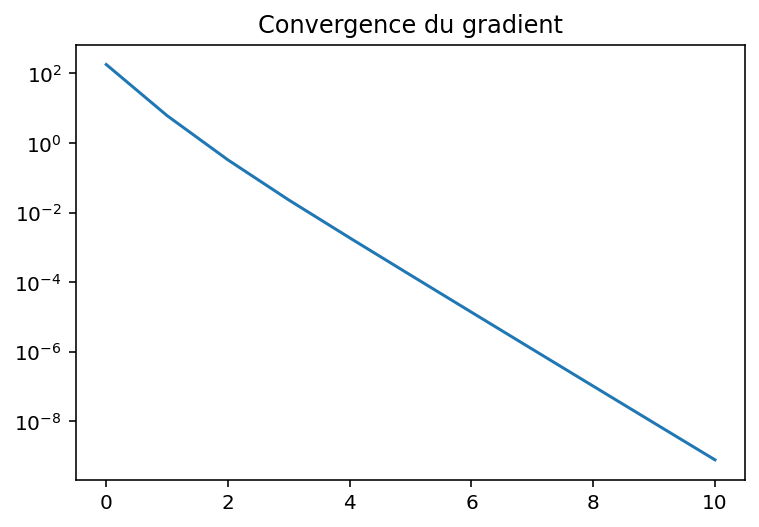

In [12]:
plt.plot(np.arange(err.shape[0]), err)
plt.title('Convergence du gradient')
plt.semilogy();

#### Pour le gradient conjugué

In [13]:
err = gradient_conjugué(A, x0, b, convergence=True)

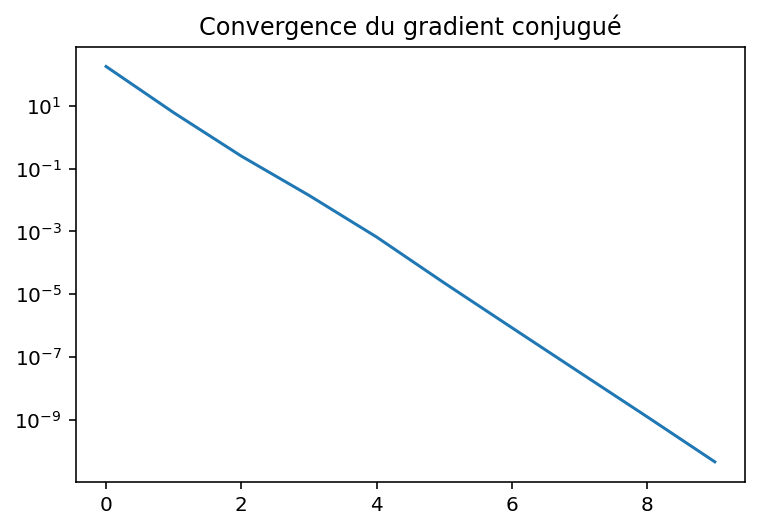

In [14]:
plt.plot(np.arange(err.shape[0]), err)
plt.title('Convergence du gradient conjugué')
plt.semilogy();

Argh, le gradient conjugué n'est pas la révolution prédite !

## Un cas réel

Logiquement vous devriez être décu aussi on va tester avec un problème réel qui correspond à cet exemple
de l'[équation de Poisson](https://doc.freefem.org/tutorials/poisson.html). Le système matriciel de ce problème est téléchargeable 
[ici](https://www.lrde.epita.fr/~ricou/cama/data/Ab.npz). Une fois le fichier sauvé, pour récupérer
A et b faites :


In [15]:
npz = np.load('/tmp/Ab.npz',allow_pickle=True)
A = npz['A']
b = npz['b']
A.shape

(2023, 2023)

* Faites une étude rapide de A, indiquez quel pourcentage des valeurs de A est différent de 0. Afficher l'image de la matrice avec `plt.imshow(A)` (faire une grande image pour voir quelque chose).
* Refaites la comparaison entre les deux méthodes avec ce système matriciel.
* Regardez la documentation de `lin.solve` de Scipy (en particulier les options) et comparer `lin.solve` à vos deux algorithmes.

In [16]:
print(A.min(), A.max())

-1.5693731138089555 4.357203686821435


In [17]:
diff0 = (A != 0).sum() / (A.shape[0] * A.shape[1])
print(f"Pourcentage de valeurs != 0 : {100 * diff0:.3} %")

Pourcentage de valeurs != 0 : 0.339 %


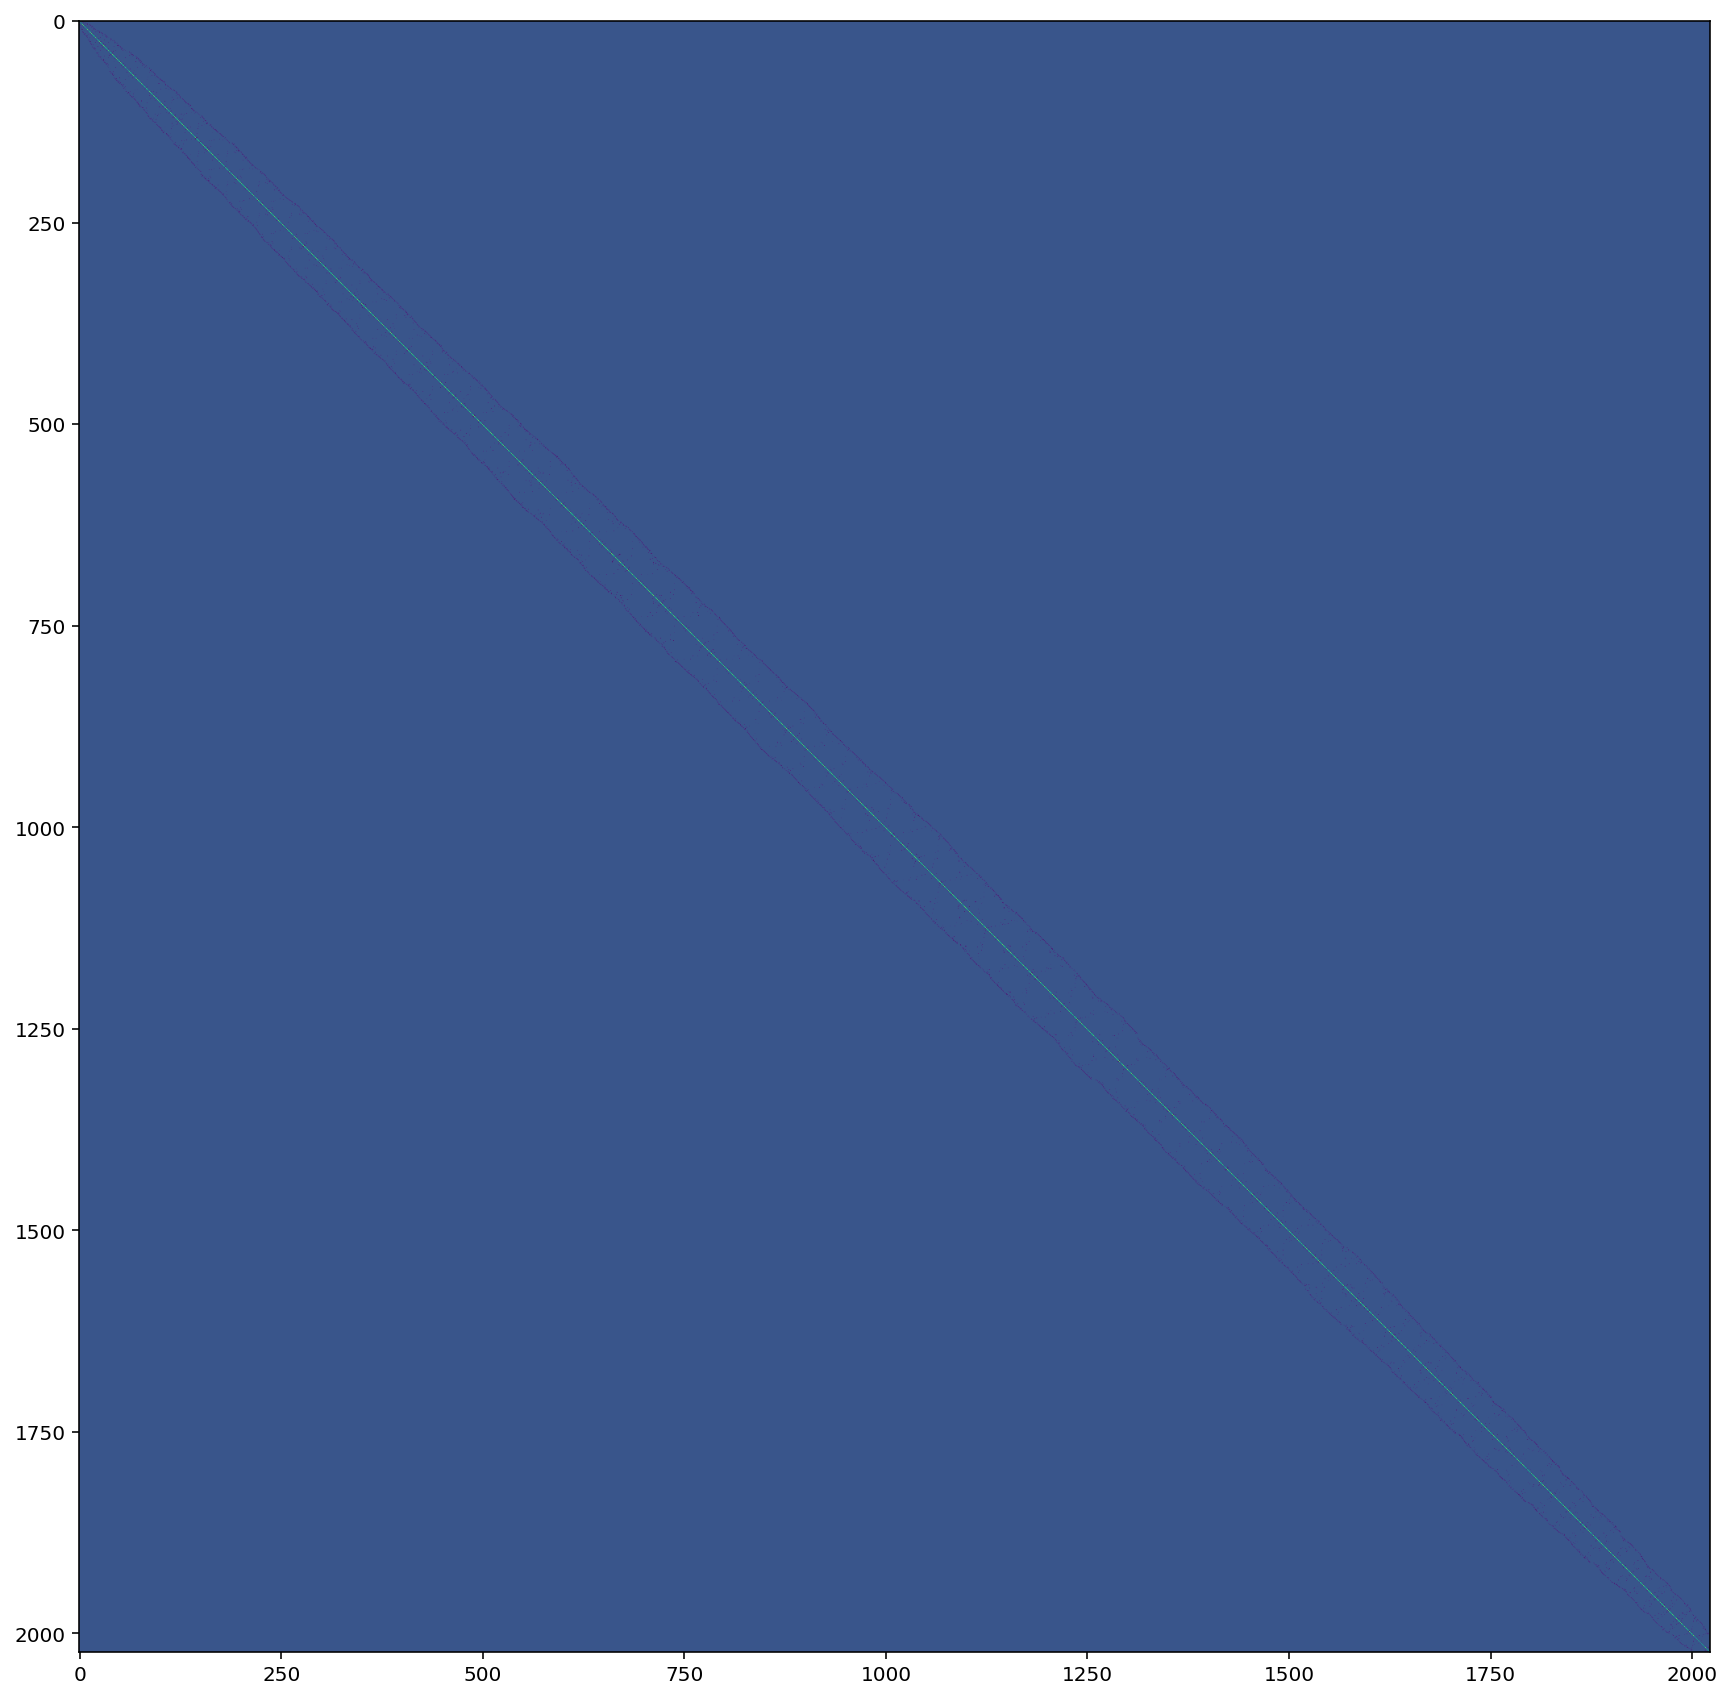

In [18]:
plt.figure(figsize=(15,15))
plt.imshow(A)

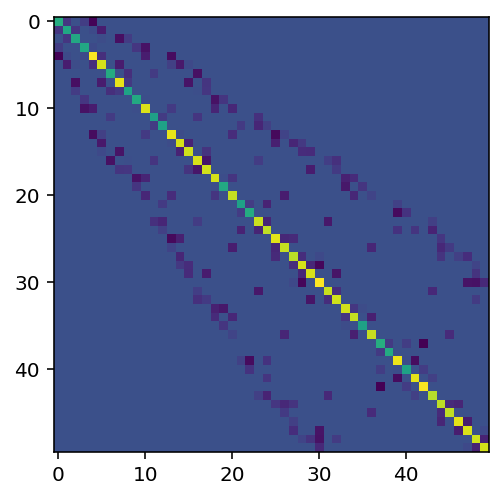

In [19]:
# zoom 
plt.imshow(A[:50, :50])

Les zéros sont le fond, le bleu foncé des valeurs négative, les autres des valeurs positives. On voit la structure du maillage qui a généré la simulation numérique. Chaque ligne et chaque colonne représente un noeud. On a une valeur non nulle pour les noeuds voisins sur le maillage. Donc $A[i,j] \ne  0$ si les noeuds i et j sont voisins. Comme être voisin est symétrique, on a $A[i,j] = A[j,i]$.

Dans ce cas, la méthode pour construire la matrice à partir du maillage doit être celle des éléments finis (il existe d'autres méthodes, la plus simple étant celle des différences finies).

### Comparaison gradient simple et conjugué

In [20]:
%time err = gradient_conjugué(A, np.zeros(len(A)), b, convergence=True)

CPU times: user 5.99 s, sys: 842 ms, total: 6.83 s
Wall time: 907 ms


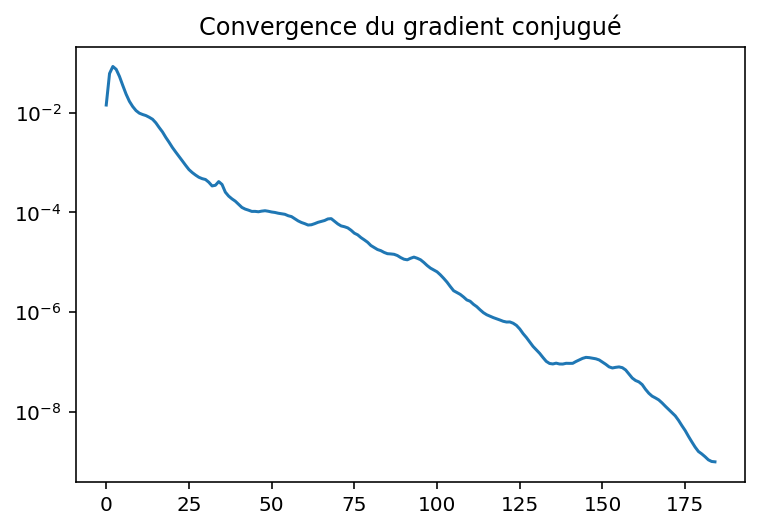

In [21]:
plt.plot(np.arange(err.shape[0]), err)
plt.title('Convergence du gradient conjugué')
plt.semilogy();

In [22]:
# le gradient simple

%time err = gradient(A, np.zeros(len(A)), b, convergence=True, max_iterations=10000)

CPU times: user 4min 11s, sys: 30.7 s, total: 4min 42s
Wall time: 36.7 s


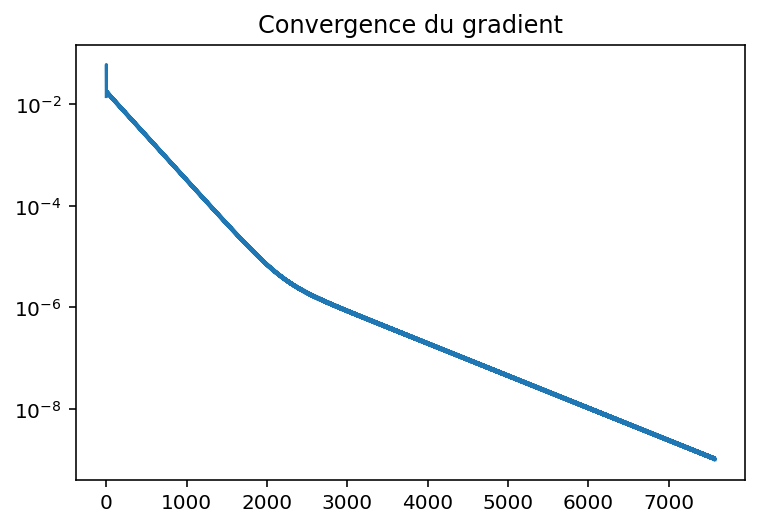

In [23]:
plt.plot(np.arange(err.shape[0]), err)
plt.title('Convergence du gradient')
plt.semilogy();

On voit la supériorité du gradient conjugué tant en nombre d'itérations (175 contre 7800) qu'en temps de calcul (environ 40 fois plus rapide).

### Comparaison avec `lin.solve` de Scipy

On utilise la version de Scipy car elle tire avantage du fait que A soit définie positive.

In [27]:
import scipy.linalg as lin
%time x = lin.solve(A, b, assume_a='pos')  # cf la doc de solve pour l'utiliser de facon optimale

CPU times: user 811 ms, sys: 355 ms, total: 1.17 s
Wall time: 202 ms


<timed exec>:1: LinAlgWarning: Ill-conditioned matrix (rcond=1.15876e-18): result may not be accurate.


In [25]:
r = A @ x - b
r @ r

3.211210706710735e-25

On note aussi `lin.solve` est plus rapide et sa solution est nettement meilleure... `lin.solve` utilise une méthode directe ici. Cela est dû au fait que Scipy utilise la bibliothèque Lapack (qui est imbatable).

### Le gradient conjugué de Scipy (avec Lapack)

Le gradient conjugué à tout son sens pour les matrices creuses aussi il est dans la partie "sparse" de Scipy.
On a vu que notre matrice à plus de 99 % de valeur nulles ce qui en fait bien une matrice creuse. Aussi je
la charge dans le format COO (téléchargez __[Acoo.npz](https://www.lrde.epita.fr/~ricou/cama/data/Acoo.npz)__) qui ne stocke que les valeurs non nulles et

In [26]:
import scipy.sparse as sparse
from scipy.sparse.linalg import cg

Ac = sparse.load_npz('/tmp/Acoo.npz')
print("Ac.shape =", Ac.shape)
%time x = cg(Ac, b)

Ac.shape = (2023, 2023)
CPU times: user 10.3 ms, sys: 34 µs, total: 10.3 ms
Wall time: 10.3 ms


On gagne un ordre de grandeur.